### Advanced Machine Learning

# Home Exercise #1

Assignment Due: 21/03/21 23:59

Jonathan Schler


In [1]:
student1Name="Alexander Kruglyak" # student1 name here
student1ID="323637736" # student1 ID here


student2Name="Sofya Zubtsovsky" # student2 name here
student2ID="337839112" # student2 ID here


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV, ElasticNet
from sklearn.impute import KNNImputer
import seaborn as sns

%matplotlib inline

# add more imports as needed

## Task 1 Regression on Ames Housing Dataset (60 Points)

You can load the Ames housing dataset from <br>
http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls <br>
You can find a description of the variables here: <br>
http://jse.amstat.org/v19n3/decock/DataDocumentation.txt <br>
Take note that for categorical variables, NA here does not mean a missing value, but should be treated as a separate category.

In [3]:
df = pd.read_excel("AmesHousing.xls")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


### Question 1.1
Visualize the univariate distribution of each continuous attribute, and the distribution of the target. Make sure you skip the string\categorial columns (you can do it using call to `select_dtypes(exclude=['object'])`).

Do you notice anything? Is there something that might require special treatment?

In [4]:
# TODO: should we skip more: for example 'MS subclass'
dropped_df = df.drop(["SalePrice", "PID", "Order"], axis=1)
numerical_df = dropped_df.select_dtypes(exclude=['object'])
print (len(df.columns))
print (len(dropped_df.columns))
print (len(numerical_df.columns))

82
79
36


In [5]:
y = df.SalePrice
y_limit = y.max()
y.max()

755000

In [6]:
features_description = {
    "MS SubClass": "type of dwelling involved in the sale",
    "Lot Frontage": "Linear feet of street connected to property",
    "Lot Area": "Lot size in square feet",
    "Overall Qual": "Rates the overall material and finish of the house",
    "Overall Cond": "Rates the overall condition of the house",
    "Year Built": "Original construction date",
    "Year Remod/Add": "Remodel date (same as construction date if no remodeling or additions)",
    "Mas Vnr Area": "Masonry veneer area in square feet",
    "BsmtFin SF 1": "Type 1 finished square feet",
    "BsmtFin SF 2": "Type 2 finished square feet",
    "Bsmt Unf SF": "Unfinished square feet of basement area",
    "Total Bsmt SF": "Total square feet of basement area",
    "1st Flr SF": "First Floor square feet",
    "2nd Flr SF": "Second floor square feet",
    "Low Qual Fin SF": "Low quality finished square feet (all floors)",
    "Gr Liv Area": "Above grade (ground) living area square feet",
    "Bsmt Full Bath": "Basement full bathrooms",
    "Bsmt Half Bath": "Basement half bathrooms",
    "Bsmt Full Bath": "Basement full bathrooms",
    "Full Bath": "Full bathrooms above grade",
    "Half Bath": "Half baths above grade",
    "Fireplaces": "Number of fireplaces",
    "Misc Val": "Value of miscellaneous feature",
    "3Ssn Porch": "Three season porch area in square feet"
}

title_font = {
        'color':  'darkblue',
        'weight': 'normal',
        'size': 20,
        }
labels_font = {
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

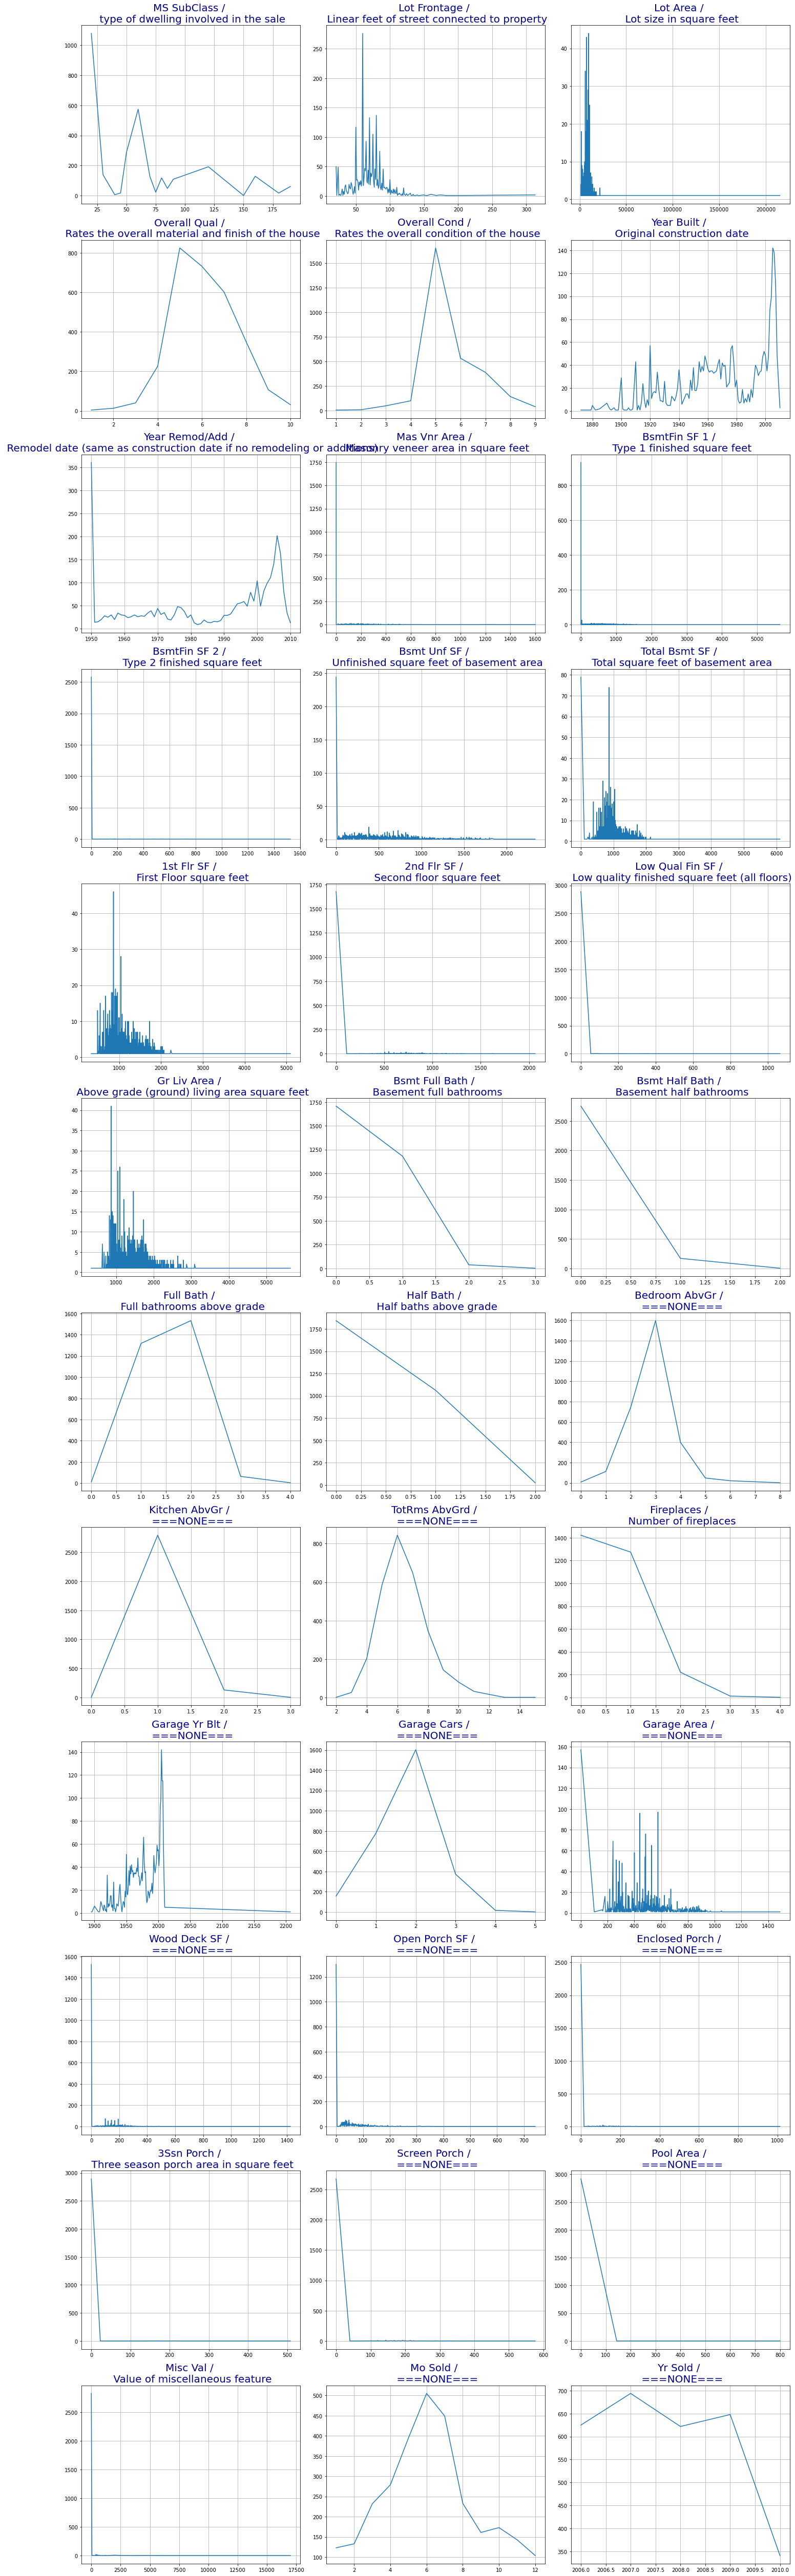

In [7]:
fig, axes = plt.subplots(12, 3, figsize=(20, 70))
#plot the distribution of numerical variables
for i, ax in enumerate(axes.ravel()):
    feature_name = numerical_df.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    y = numerical_df[feature_name].value_counts().sort_index()
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
    ax.plot(y)
    ax.grid()
plt.tight_layout()


### The plot allows to define the following:
most of the feautures must be scaled and normalized:
<ul>
<li>lot frontage, lot area, total basement SF, garage year build and many other features aren't distributed around the median (there is a skew of the data)</li>
<li>second floor, low quality SF, area and other features have a number of extreme values, and should be presented using log axis</li>
<li>features have different scale, distribution and standard deviation</li></ul>

### Question 1.2
Visualize the dependency of the target on each continuous feature (2d scatter plot).

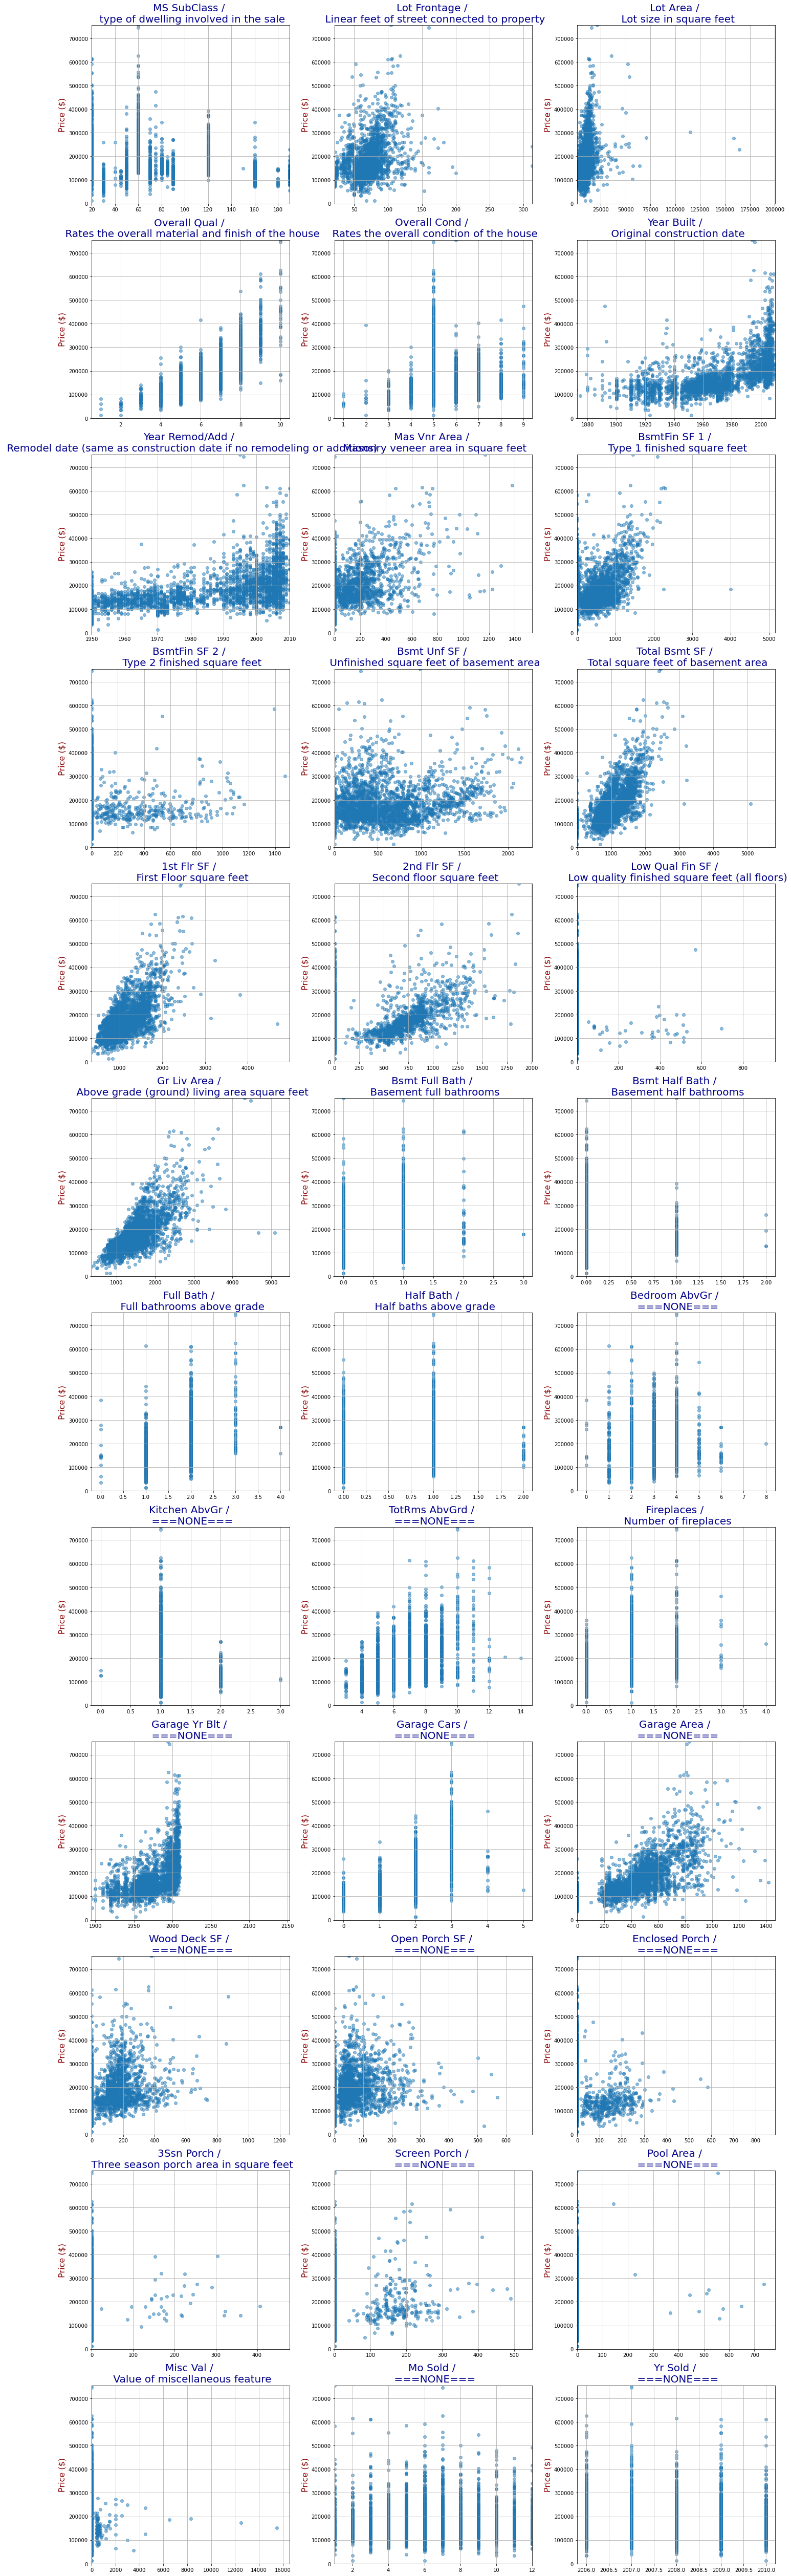

In [8]:
fig, axes = plt.subplots(12, 3, figsize=(20, 70))
y = df.SalePrice

for i, ax in enumerate(axes.ravel()):
    X_col = numerical_df.iloc[:, i]
    ax.set_ylim(0, y_limit)
    if X_col.nunique() > 10:
        ax.set_xlim(X_col.quantile(q=.0001), X_col.quantile(q=.9999))
        
    ax.scatter(X_col, y, alpha=.5)

    feature_name = numerical_df.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
    ax.set_ylabel("Price ($)", fontdict=labels_font)
    ax.grid()
    
plt.tight_layout()

### Question 1.3
Split data in training and test set. Do not use the test-set unless for a final evaluation in 1.6.
For each categorical variable, cross-validate a Linear Regression model using just this variable
(one-hot-encoded). Visualize the relationship of the categorical variables that provide the best
R^2 value with the target.

<AxesSubplot:>

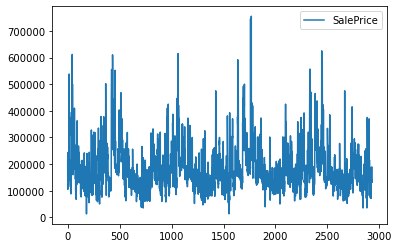

In [9]:
#plot the price to see how it's spreaded across the indexes
df.plot.line(y='SalePrice')


In [10]:
X = dropped_df
#get dummies
X_dummies = pd.get_dummies(X)
#method 1 - split data in the ordinary way
# what about stratify???
X_train, X_test, y_train, y_test = train_test_split(X_dummies,y,random_state=0)

#method 2 - split with stratification
nof_bins = 50 #can be adjusted
bins = np.linspace(np.min(y), len(y), nof_bins)
# split continious SalePrice  into bins to make it 'categorical'
y_binned = np.digitize(y, bins)
X_stratified_train, X_stratified_test, y_stratified_train, y_stratified_test = train_test_split(X_dummies, y, stratify = y_binned,random_state=0)
print ('median without stratify: train %f test %f\nmedian with stratify: train %f, test %f' % (np.median(y_train), np.median(y_test),np.median(y_stratified_train), np.median(y_stratified_test)))

#TBD check if the order between split and get_dummies is correct

median without stratify: train 160000.000000 test 162500.000000
median with stratify: train 160500.000000, test 159000.000000


### Question 1.4
Use ColumnTransformer and pipeline to encode categorical variables. Evaluate Linear
Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default
parameters. Does scaling the data (within the pipeline) with StandardScaler help?

In [11]:
#take only categorical values from train set
categorical = X_train.dtypes == object

scores = {}
preprocess = make_column_transformer(
    (StandardScaler(), ~categorical),
    (OneHotEncoder(), categorical))
#disregard warning
rergressors = [LinearRegression(),Ridge(),Lasso(),ElasticNet()] 
for regr in rergressors:
    scaled_pipe = make_pipeline(KNNImputer(),preprocess,regr) #important to impute NaN values to avoid errors on regression
    non_caled_pipe = make_pipeline(KNNImputer(),regr)
    scores[regr] = (np.mean(cross_val_score(scaled_pipe, X_train, y_train)),np.mean(cross_val_score(non_caled_pipe, X_train, y_train)))

/home/zsofya/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70229315725.9964, tolerance: 1087566188.3808792
  model = cd_fast.enet_coordinate_descent(
/home/zsofya/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91650418136.43036, tolerance: 1166497669.2995465
  model = cd_fast.enet_coordinate_descent(
/home/zsofya/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182909066086.1269, tolerance: 1084125200.2107515
  model = cd_fast.enet_coordinate_descent(
/home/zsofya/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

In [12]:
df = pd.DataFrame(data=scores,index=['scaled','non-scaled'],dtype=float)    
print(df)

            LinearRegression()   Ridge()   Lasso()  ElasticNet()
scaled           -1.591863e+24  0.835770  0.854448      0.881445
non-scaled        8.302720e-01  0.869184  0.856839      0.847289


### Question 1.5
Tune the parameters of the models using GridSearchCV. Do the results improve?
Visualize the dependence of the validation score on the parameters for Ridge, Lasso and
ElasticNet.

In [14]:
categorical = X_train.dtypes == object
preprocess = make_column_transformer(
    (StandardScaler(), ~categorical),
    (OneHotEncoder(), categorical))

In [15]:
pipe = Pipeline([('imputer', KNNImputer()),
                 ('scaler', preprocess),
                 ('regressor', Ridge())])

In [35]:
def plot_alpha_score(gridcv_results):
    results = pd.DataFrame(gridcv_results)
    results.plot('param_regressor__alpha', 'mean_train_score')
    results.plot('param_regressor__alpha', 'mean_test_score', ax=plt.gca())
    plt.fill_between(results.param_regressor__alpha.astype(np.float),
                     results['mean_train_score'] + results['std_train_score'],
                     results['mean_train_score'] - results['std_train_score'], alpha=0.2)
    plt.fill_between(results.param_regressor__alpha.astype(np.float),
                     results['mean_test_score'] + results['std_test_score'],
                     results['mean_test_score'] - results['std_test_score'], alpha=0.2)
    plt.legend()
    plt.xscale("log")

In [ ]:
def plot_alpha_l1_score(gridcv_results):
    res = pd.pivot_table(pd.DataFrame(gridcv_results),
    values='mean_test_score', index='param_regressor__alpha', columns='param_regressor__l1_ratio')
    res = res.set_index(res.index.values.round(4))
    sns.heatmap(res, annot=True, fmt=".3g", vmin=0.6)

In [25]:
#TBD decide if we need to use array of regressor instead of validate one by one
# multiple_param_grid = [{'imputer': [KNNImputer()],
#             'regressor': [Ridge()],
#             'regressor__alpha': np.logspace(-3, 3, 13),
#             'scaler': [preprocess]},
#             {'imputer': [KNNImputer()],
#              'regressor': [Lasso()],
#             'regressor__alpha': np.logspace(-3, 0, 13),
#             'scaler': [preprocess]},
#             {'imputer': [KNNImputer()],
#             'regressor': [ElasticNet()],
#             'regressor__alpha': np.logspace(-4, -1, 10),
#             'regressor__l1_ratio': [0.01, .1, .5, .9, .98, 1],
#             'scaler': [preprocess]}
#              ]
# grid = GridSearchCV(pipe, multiple_param_grid,n_jobs=-1,return_train_score=True,cv=10)
# grid.fit(X_train, y_train)

In [30]:
# RIDGE
ridge_param_grid = {'imputer': [KNNImputer()],
            'regressor': [Ridge()],
            'regressor__alpha': np.logspace(-3, 3, 13),
            'scaler': [preprocess]}
ridge_grid = GridSearchCV(pipe, ridge_param_grid,n_jobs=-1,return_train_score=True,cv=10)
ridge_grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('scaler',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         MS SubClass               True
Lot Frontage              True
Lot Area                  True
Overall Qual              True
Overall Cond              True
                          ... 
Sale Condition_AdjLand    True
Sale Condition_Alloca     True
Sale Condition_Family     True
Sale Condition_Normal     True
Sale Condition_Partial    True
Length: 3...
Sale Condition_Normal     True
Sale Condition_Partial    True
Length: 304, dtype: bool),
                                                                    ('onehotencoder',
                                                                     OneHotEncod

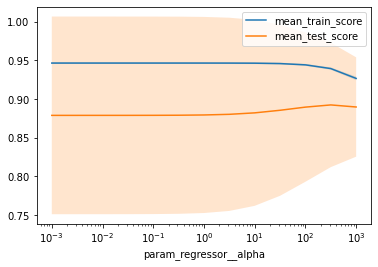

In [36]:
plot_alpha_score(ridge_grid.cv_results_)

In [31]:
# LASSO
lasso_param_grid =  {'imputer': [KNNImputer()],
             'regressor': [Lasso()],
            'regressor__alpha': np.logspace(-3, 0, 13),
            'scaler': [preprocess]}
lasso_grid = GridSearchCV(pipe, lasso_param_grid,n_jobs=-1,return_train_score=True,cv=10)
lasso_grid.fit(X_train, y_train)

/home/zsofya/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98029488016.65192, tolerance: 1391468446.6790373
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('scaler',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         MS SubClass               True
Lot Frontage              True
Lot Area                  True
Overall Qual              True
Overall Cond              True
                          ... 
Sale Condition_AdjLand    True
Sale Condition_Alloca     True
Sale Condition_Family     True
Sale Condition_Normal     True
Sale Condition_Partial    True
Length: 3...
Sale Condition_Normal     True
Sale Condition_Partial    True
Length: 304, dtype: bool),
                                                                    ('onehotencoder',
                                                                     OneHotEncod

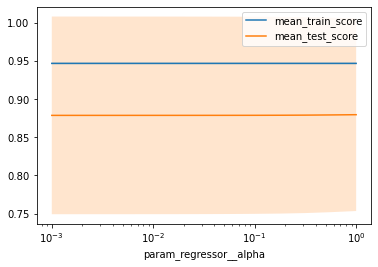

In [37]:
plot_alpha_score(lasso_grid.cv_results_)

In [32]:
# ELASTIC NET
elastic_param_grid = {'imputer': [KNNImputer()],
            'regressor': [ElasticNet()],
            'regressor__alpha': np.logspace(-4, -1, 10),
            'regressor__l1_ratio': [0.01, .1, .5, .9, .98, 1],
            'scaler': [preprocess]}
elastic_grid = GridSearchCV(pipe, elastic_param_grid,n_jobs=-1,return_train_score=True,cv=10)
elastic_grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('scaler',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         MS SubClass               True
Lot Frontage              True
Lot Area                  True
Overall Qual              True
Overall Cond              True
                          ... 
Sale Condition_AdjLand    True
Sale Condition_Alloca     True
Sale Condition_Family     True
Sale Condition_Normal     True
Sale Condition_Partial    True
Length: 3...
Sale Condition_Normal     True
Sale Condition_Partial    True
Length: 304, dtype: bool),
                                                                    ('onehotencoder',
                                                                     OneHotEncod

In [39]:
plot_alpha_l1_score(elastic_grid.cv_results_)

KeyError: 'param_alpha'

### Question 1.6
Visualize the coefficients of the resulting models. Do they agree on which features are
important?

In [ ]:
# your code here

## Task 2 Classification on the Telco-churn dataset (40 points)

You can download the dataset and see it’s description at <br>
https://www.kaggle.com/blastchar/telco-customer-churn

### Question 2.1

Load the data from the file into a DataFrame

In [ ]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.head()
# df.iloc["2229-VWQJH"]

### Question 2.2

Split data into training and test set. Build a pipeline for dealing with categorical variables.
Evaluate Logistic Regression and nearest centroids using
cross-validation. How different are the results? How does scaling the continuous features with
StandardScaler influence the results?

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y = df.Churn
x = df.drop(["Churn", "customerID"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(x), y, random_state=0)

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
print(f"accuracy: {knn.score(X_test, y_test):.2f}")

### Question 2.3

Tune the parameters using GridSearchCV. Do the results improve?

In [ ]:
# your code here

### Question 2.4

Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the
parameters that are found change? Do they change if you change the random seed of the
shuffling? Or if you change the random state of the split into training and test data?

In [ ]:
# your code here

Good Luck!